In [150]:
import cv2
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt

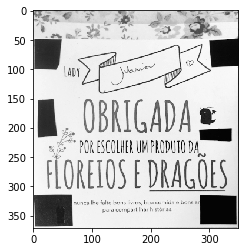

In [151]:
# Load reference image and convert it to gray scale
referenceImage = cv2.imread('./img/referenceImage.jpg', cv2.IMREAD_GRAYSCALE)

# Show image
plt.imshow(referenceImage, cmap='gray')
plt.show()

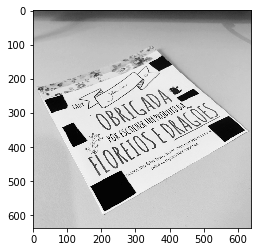

In [152]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('./img/sourceImage_04.jpg', cv2.IMREAD_GRAYSCALE) 

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

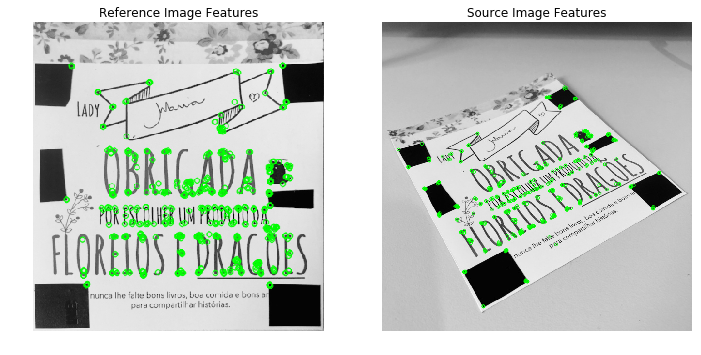

In [153]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)

# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

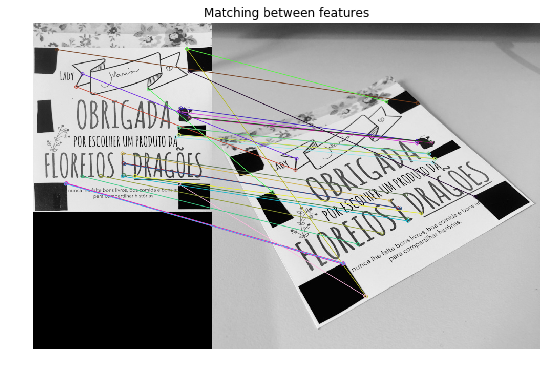

In [154]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.title('Matching between features')
    plt.show()
    
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

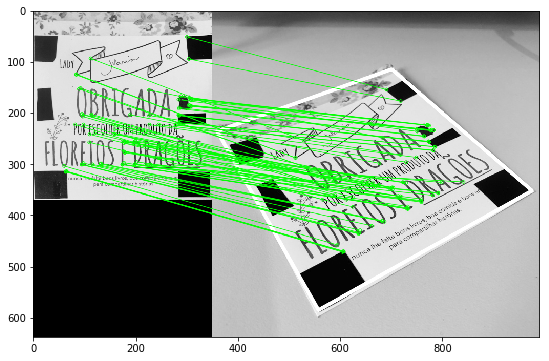

In [155]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)
    
else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

In [156]:
import os
import pygame
from OpenGL.GL import *


class OBJ:
    generate_on_init = True
    @classmethod
    def loadTexture(cls, imagefile):
        surf = pygame.image.load(imagefile)
        image = pygame.image.tostring(surf, 'RGBA', 1)
        ix, iy = surf.get_rect().size
        texid = glGenTextures(1)
        glBindTexture(GL_TEXTURE_2D, texid)
        glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MIN_FILTER, GL_LINEAR)
        glTexParameteri(GL_TEXTURE_2D, GL_TEXTURE_MAG_FILTER, GL_LINEAR)
        glTexImage2D(GL_TEXTURE_2D, 0, GL_RGBA, ix, iy, 0, GL_RGBA, GL_UNSIGNED_BYTE, image)
        return texid

    @classmethod
    def loadMaterial(cls, filename):
        contents = {}
        mtl = None
        dirname = os.path.dirname(filename)

        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'newmtl':
                mtl = contents[values[1]] = {}
            elif mtl is None:
                raise ValueError("mtl file doesn't start with newmtl stmt")
            elif values[0] == 'map_Kd':
                # load the texture referred to by this declaration
                mtl[values[0]] = values[1]
                imagefile = os.path.join(dirname, mtl['map_Kd'])
                mtl['texture_Kd'] = cls.loadTexture(imagefile)
            else:
                mtl[values[0]] = list(map(float, values[1:]))
        return contents

    def __init__(self, filename, swapyz=False):
        """Loads a Wavefront OBJ file. """
        self.vertices = []
        self.normals = []
        self.texcoords = []
        self.faces = []
        self.gl_list = 0
        dirname = os.path.dirname(filename)

        material = None
        for line in open(filename, "r"):
            if line.startswith('#'): continue
            values = line.split()
            if not values: continue
            if values[0] == 'v':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.vertices.append(v)
            elif values[0] == 'vn':
                v = list(map(float, values[1:4]))
                if swapyz:
                    v = v[0], v[2], v[1]
                self.normals.append(v)
            elif values[0] == 'vt':
                self.texcoords.append(list(map(float, values[1:3])))
            elif values[0] in ('usemtl', 'usemat'):
                material = values[1]
            elif values[0] == 'mtllib':
                self.mtl = self.loadMaterial(os.path.join(dirname, values[1]))
            elif values[0] == 'f':
                face = []
                texcoords = []
                norms = []
                for v in values[1:]:
                    w = v.split('/')
                    face.append(int(w[0]))
                    if len(w) >= 2 and len(w[1]) > 0:
                        texcoords.append(int(w[1]))
                    else:
                        texcoords.append(0)
                    if len(w) >= 3 and len(w[2]) > 0:
                        norms.append(int(w[2]))
                    else:
                        norms.append(0)
                self.faces.append((face, norms, texcoords, material))
        if self.generate_on_init:
            self.generate()

    def generate(self):
        self.gl_list = glGenLists(1)
        glNewList(self.gl_list, GL_COMPILE)
        glEnable(GL_TEXTURE_2D)
        glFrontFace(GL_CCW)
        for face in self.faces:
            vertices, normals, texture_coords, material = face

            mtl = self.mtl[material]
            if 'texture_Kd' in mtl:
                # use diffuse texmap
                glBindTexture(GL_TEXTURE_2D, mtl['texture_Kd'])
            else:
                # just use diffuse colour
                glColor(*mtl['Kd'])

            glBegin(GL_POLYGON)
            for i in range(len(vertices)):
                if normals[i] > 0:
                    glNormal3fv(self.normals[normals[i] - 1])
                if texture_coords[i] > 0:
                    glTexCoord2fv(self.texcoords[texture_coords[i] - 1])
                glVertex3fv(self.vertices[vertices[i] - 1])
            glEnd()
        glDisable(GL_TEXTURE_2D)
        glEndList()

    def render(self):
        glCallList(self.gl_list)

    def free(self):
        glDeleteLists([self.gl_list])


In [157]:
#from OBJFileLoader import *
from objloader_simple import *

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('./models/chair.obj', swapyz=True)

In [158]:
def projection_matrix(camera_parameters, homography):
    
    homography = homography * (-1)
    rot_and_transl = np.dot(np.linalg.inv(camera_parameters), homography)
    col_1 = rot_and_transl[:, 0]
    col_2 = rot_and_transl[:, 1]
    col_3 = rot_and_transl[:, 2]
    
    # normalise vectors
    l = math.sqrt(np.linalg.norm(col_1, 2) * np.linalg.norm(col_2, 2))
    rot_1 = col_1 / l
    rot_2 = col_2 / l
    translation = col_3 / l
    
    # compute the orthonormal basis
    c = rot_1 + rot_2
    p = np.cross(rot_1, rot_2)
    d = np.cross(c, p)
    rot_1 = np.dot(c / np.linalg.norm(c, 2) + d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_2 = np.dot(c / np.linalg.norm(c, 2) - d / np.linalg.norm(d, 2), 1 / math.sqrt(2))
    rot_3 = np.cross(rot_1, rot_2)
    
    # finally, compute the 3D projection matrix from the model to the current frame
    projection = np.stack((rot_1, rot_2, rot_3, translation)).T
    
    return np.dot(camera_parameters, projection)

In [159]:
# project cube or model
def render(img, obj, projection, model, color=False):

    vertices = obj.vertices
    scale_matrix = np.eye(3) * 6
    h, w = model.shape

    for face in obj.faces:
        face_vertices = face[0]
        points = np.array([vertices[vertex - 1] for vertex in face_vertices])
        points = np.dot(points, scale_matrix)
        # render model in the middle of the reference surface. To do so,
        # model points must be displaced
        points = np.array([[p[0] + w / 2, p[1] + h / 2, p[2]] for p in points])
        dst = cv2.perspectiveTransform(points.reshape(-1, 1, 3), projection)
        imgpts = np.int32(dst)

        cv2.fillConvexPoly(img, imgpts, (80, 27, 211))
    return img

In [160]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, _ = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    frame = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)
    
    # obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)  
    
    # project cube or model
    frame = render(frame, obj, projection, referenceImage, False)

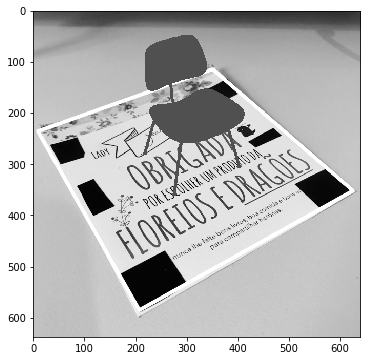

In [163]:
# Show image
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap='gray')
plt.savefig('./results/chair_test01.png')
plt.show()

In [ ]:
#----------test02--------------

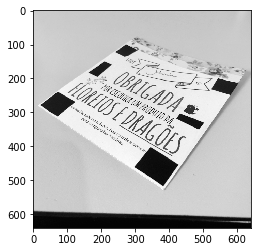

In [164]:
# Load the source image and convert it to gray scale
sourceImage = cv2.imread('./img/sourceImage_02.jpg', cv2.IMREAD_GRAYSCALE) 

# Show image
plt.imshow(sourceImage, cmap='gray')
plt.show()

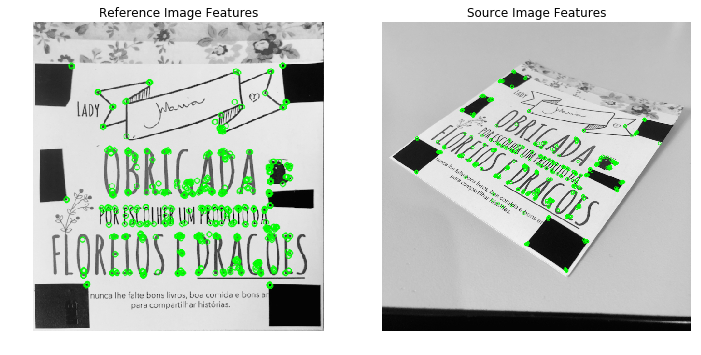

In [165]:
# Initiate ORB detector
orb = cv2.ORB_create()

# find the keypoints with ORB
referenceImagePts = orb.detect(referenceImage, None)
sourceImagePts = orb.detect(sourceImage, None)

# compute the descriptors with ORB
referenceImagePts, referenceImageDsc = orb.compute(referenceImage, referenceImagePts)
sourceImagePts, sourceImageDsc = orb.compute(sourceImage, sourceImagePts)

#  Paint the key points over the original image
referenceImageFeatures = cv2.drawKeypoints(referenceImage, referenceImagePts,
                                           referenceImage, color=(0,255,0), flags=0)
sourceImageFeatures = cv2.drawKeypoints(sourceImage, sourceImagePts,
                                           sourceImage, color=(0,255,0), flags=0)


# Show image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(referenceImageFeatures, cmap='gray')
plt.title('Reference Image Features')
plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(sourceImageFeatures, cmap='gray')
plt.title('Source Image Features')
plt.tight_layout()
plt.show()

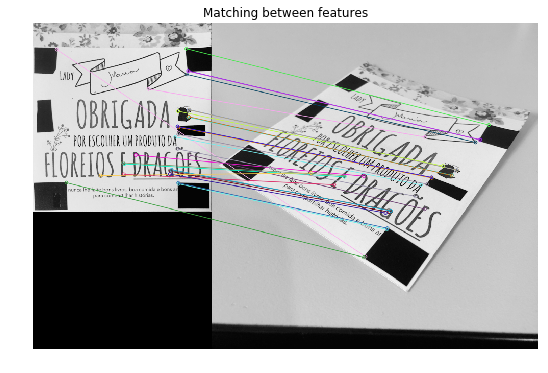

In [166]:
MIN_MATCHES = 30
            
# create brute force  matcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# Compute model keypoints and its descriptors
referenceImagePts, referenceImageDsc = orb.detectAndCompute(referenceImage, None)

# Compute scene keypoints and its descriptors
sourceImagePts, sourceImageDsc = orb.detectAndCompute(sourceImage, None)

# Match frame descriptors with model descriptors
matches = bf.match(referenceImageDsc, sourceImageDsc)

# Sort them in the order of their distance
matches = sorted(matches, key=lambda x: x.distance)

if len(matches) > MIN_MATCHES:
    # draw first 15 matches.
    idxPairs = cv2.drawMatches(referenceImage, referenceImagePts, sourceImage, sourceImagePts,
                          matches[:MIN_MATCHES], 0, flags=2)
    # show result
    plt.figure(figsize=(12, 6))
    plt.axis('off')
    plt.imshow(idxPairs, cmap='gray')
    plt.title('Matching between features')
    plt.show()
    
else:
    print("Not enough matches have been found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

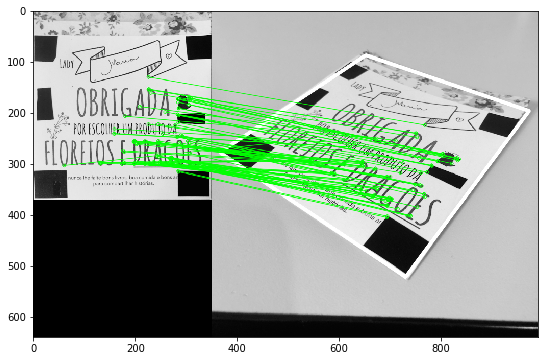

In [167]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, mask = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    sourceImageMarker = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True,
                                      255, 5, cv2.LINE_AA)
    
else:
    print("Not enough matches are found - %d/%d" % (len(matches), MIN_MATCHES))
    matchesMask = None

# Draw the matches
drawParameters = dict(matchColor=(0, 255, 0), singlePointColor=None,
                      matchesMask=matchesMask, flags=2)
result = cv2.drawMatches(referenceImage, referenceImagePts, sourceImageMarker,
                         sourceImagePts, matches, None, **drawParameters)

# Show image
plt.figure(figsize=(12, 6))
plt.imshow(result, cmap='gray')
plt.show()

In [168]:
#from OBJFileLoader import *
from objloader_simple import *

# Camera parameters
camera_parameters = np.array([[1000, 0, 320], [0, 1000, 240], [0, 0, 1]])

# Load 3D model from OBJ file
obj = OBJ('./models/chair.obj', swapyz=True)

In [170]:
# Apply the homography transformation if we have enough good matches
if len(matches) > MIN_MATCHES:
    # Get the good key points positions
    sourcePoints = np.float32([referenceImagePts[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    destinationPoints = np.float32([sourceImagePts[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)

    # Obtain the homography matrix
    homography, _ = cv2.findHomography(sourcePoints, destinationPoints, cv2.RANSAC, 5.0)
    matchesMask = mask.ravel().tolist()

    # Apply the perspective transformation to the source image corners
    h, w = referenceImage.shape
    corners = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(-1, 1, 2)
    transformedCorners = cv2.perspectiveTransform(corners, homography)

    # Draw a polygon on the second image joining the transformed corners
    frame = cv2.polylines(sourceImage, [np.int32(transformedCorners)], True, 255, 3, cv2.LINE_AA)
    
    # obtain 3D projection matrix from homography matrix and camera parameters
    projection = projection_matrix(camera_parameters, homography)  
    
    # project cube or model
    frame = render(frame, obj, projection, referenceImage, False)

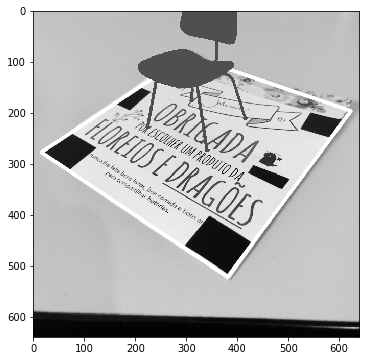

In [173]:
# Show image
plt.figure(figsize=(12, 6))
plt.imshow(frame, cmap='gray')
plt.savefig('./results/chair_test02.png')
plt.show()

In [ ]:
#Reference-->https://github.com/mafda/augmented_reality_101/blob/master/src/ar_python3_opencv4.ipynb